# Chest CT scan analysis for COVID-19 cases 

La détection des cas de COVID-19 est une étape clé dans la lutte contre l’épidémie. Si les tests antigéniques sont largement utilisés, d’autres méthodes faisant appel à l’imagerie semblent présentées un intérêt comme le souligne l’article suivant : https://www.revmed.ch/RMS/2020/RMS-N-692/Utilite-du-CT-scan-thoracique-pour-le-diagnostic-et-le-triage-des-patients-suspects-de-COVID-19 

Le dataset est accessible ici https://github.com/ShahinSHH/COVID-CT-MD et il comprend des coupes anatomiques dans la region thoracique (partie haute) et allant jusqu'à la region pelvienne (que nous n'analyserons pas)

L’acquisition d’images médicales repose sur le contraste morphologiques (constitution, densité) du matérielle organique. Ainsi, les tissus les plus denses et “durs” tel que les os apparaitrons en blanc tandis que les tissus mou ou l’air apparaitrons en sombre. Ces paramètres peuvent être modifié avant l’acquisition pour s’adapter aux différents organes à observer et pathologies potentielles. Cependant, nous nous intéresserons uniquement aux modifications sur l’image brute. 

In [1]:
# librairies pour le chargement et l'affichage des images
# neccessite l'installation des librairies pour pouvoir effectuer l'import

#pip install medpy
#pip install pydicom
#pip install pylibjpeg pylibjpeg-libjpeg pydicom

import pydicom
import pylibjpeg
import matplotlib.pyplot as plt

In [2]:
# Création des volumes d'images des cas COVID et non COVID
import os
dir = os.listdir('Covid')
volume_covid = []
for i in dir:
    volume_covid.append([pydicom.dcmread('Covid/' + i).pixel_array,i])
dir = os.listdir('Non_covid')
volume_non_covid = []
for i in dir:
    volume_non_covid.append([pydicom.dcmread('Non_covid/' + i).pixel_array,i])

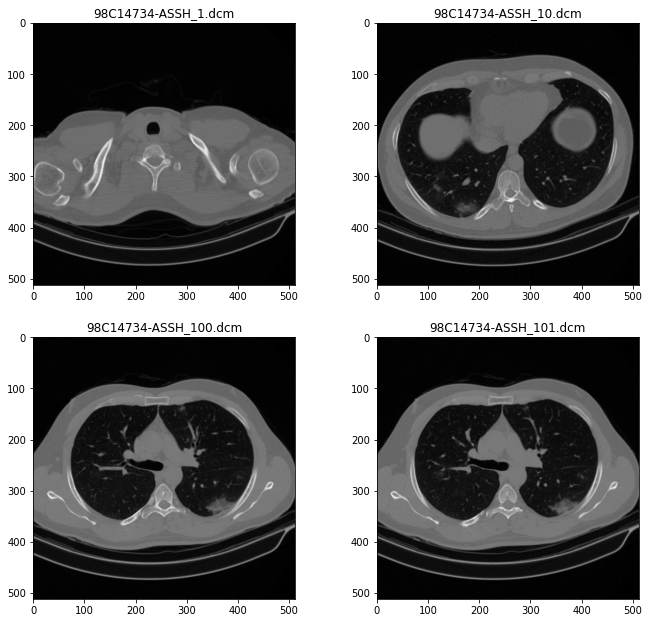

In [3]:
# Affichage des premoères images
for i,j in enumerate(volume_covid[0:4]):
    plt.rcParams["figure.figsize"] = (10,10)
    plt.subplots_adjust(bottom=0.1, right=1.0, top=0.9)
    plt.subplot(2,2,i+1,title= str(j[1]))
    plt.imshow(j[0],cmap='gray')

On observe que la première image est une coupe trés proche du bassin. La cavité pulmonaire n'est pas visible et donc pas ecploitable pour notre analyse. Nous selectionnerons donc des images de coupe thoraciques comme les suivantes.

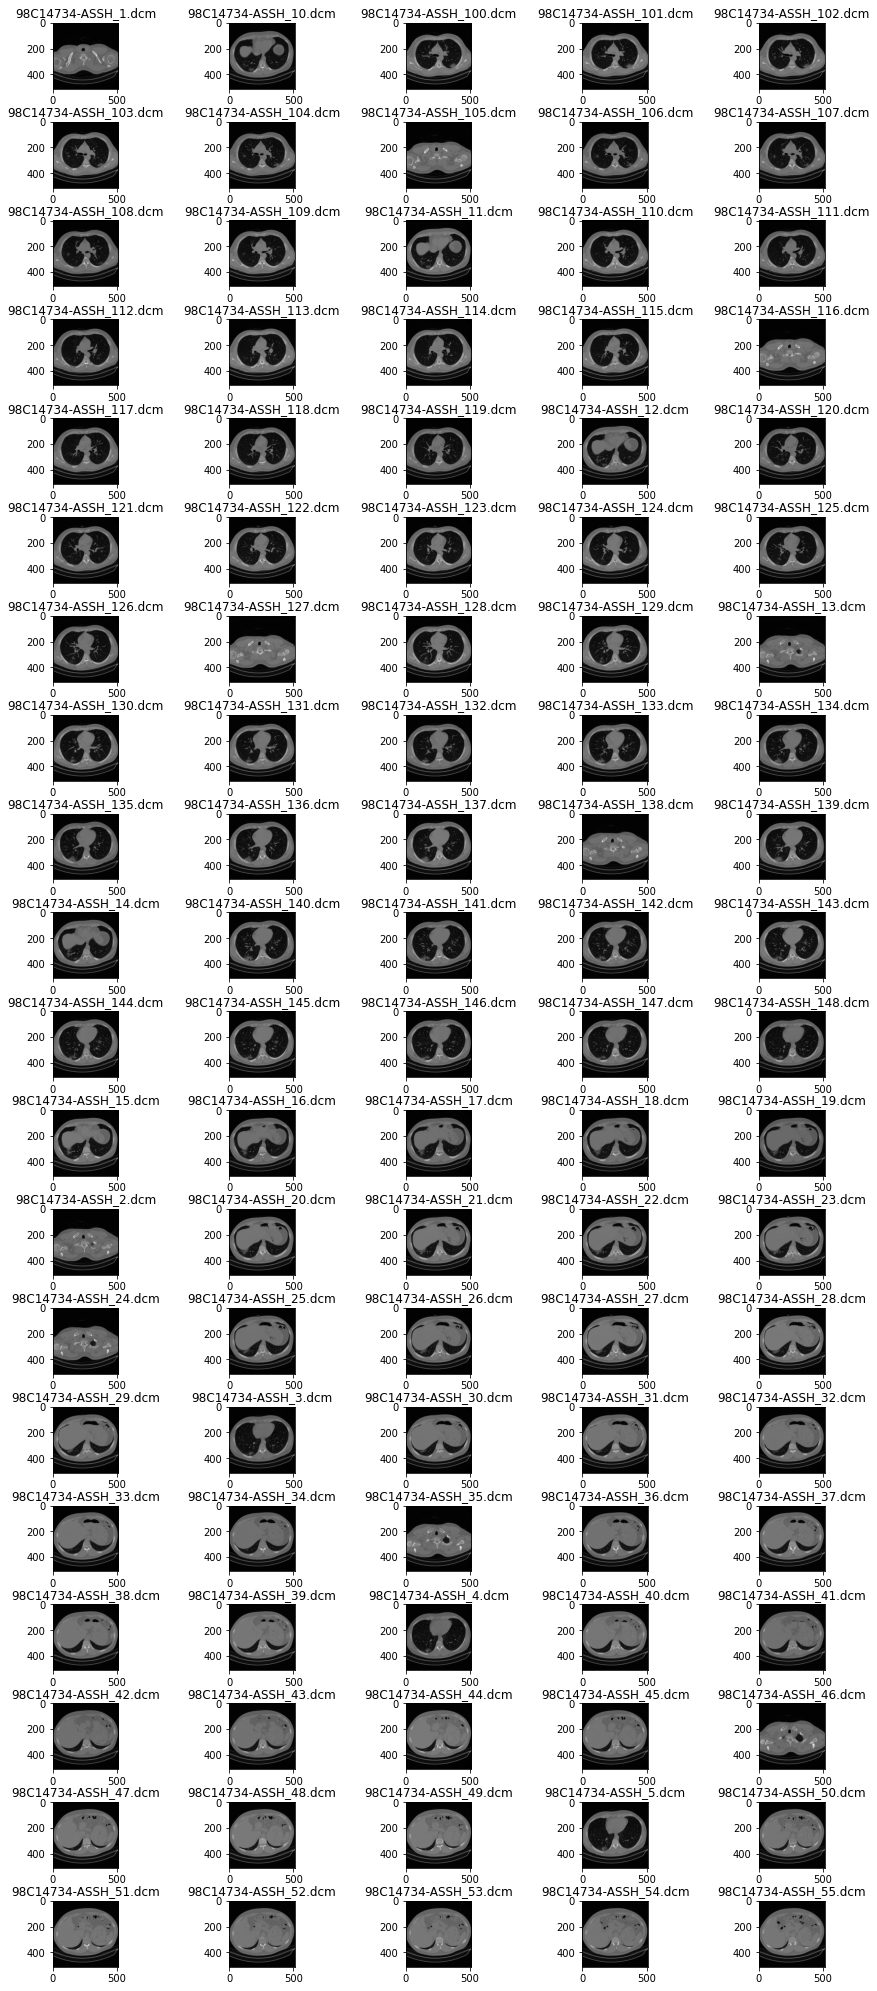

In [4]:
for i,j in enumerate(volume_covid[0:100]):
    plt.rcParams["figure.figsize"] = (30,30)
    plt.subplots_adjust(bottom=0.1, right=0.5, top=1.0, wspace=0.7, hspace=0.5)
    plt.subplot(20,5,i+1,title= str(j[1]))
    plt.imshow(j[0],cmap='gray')

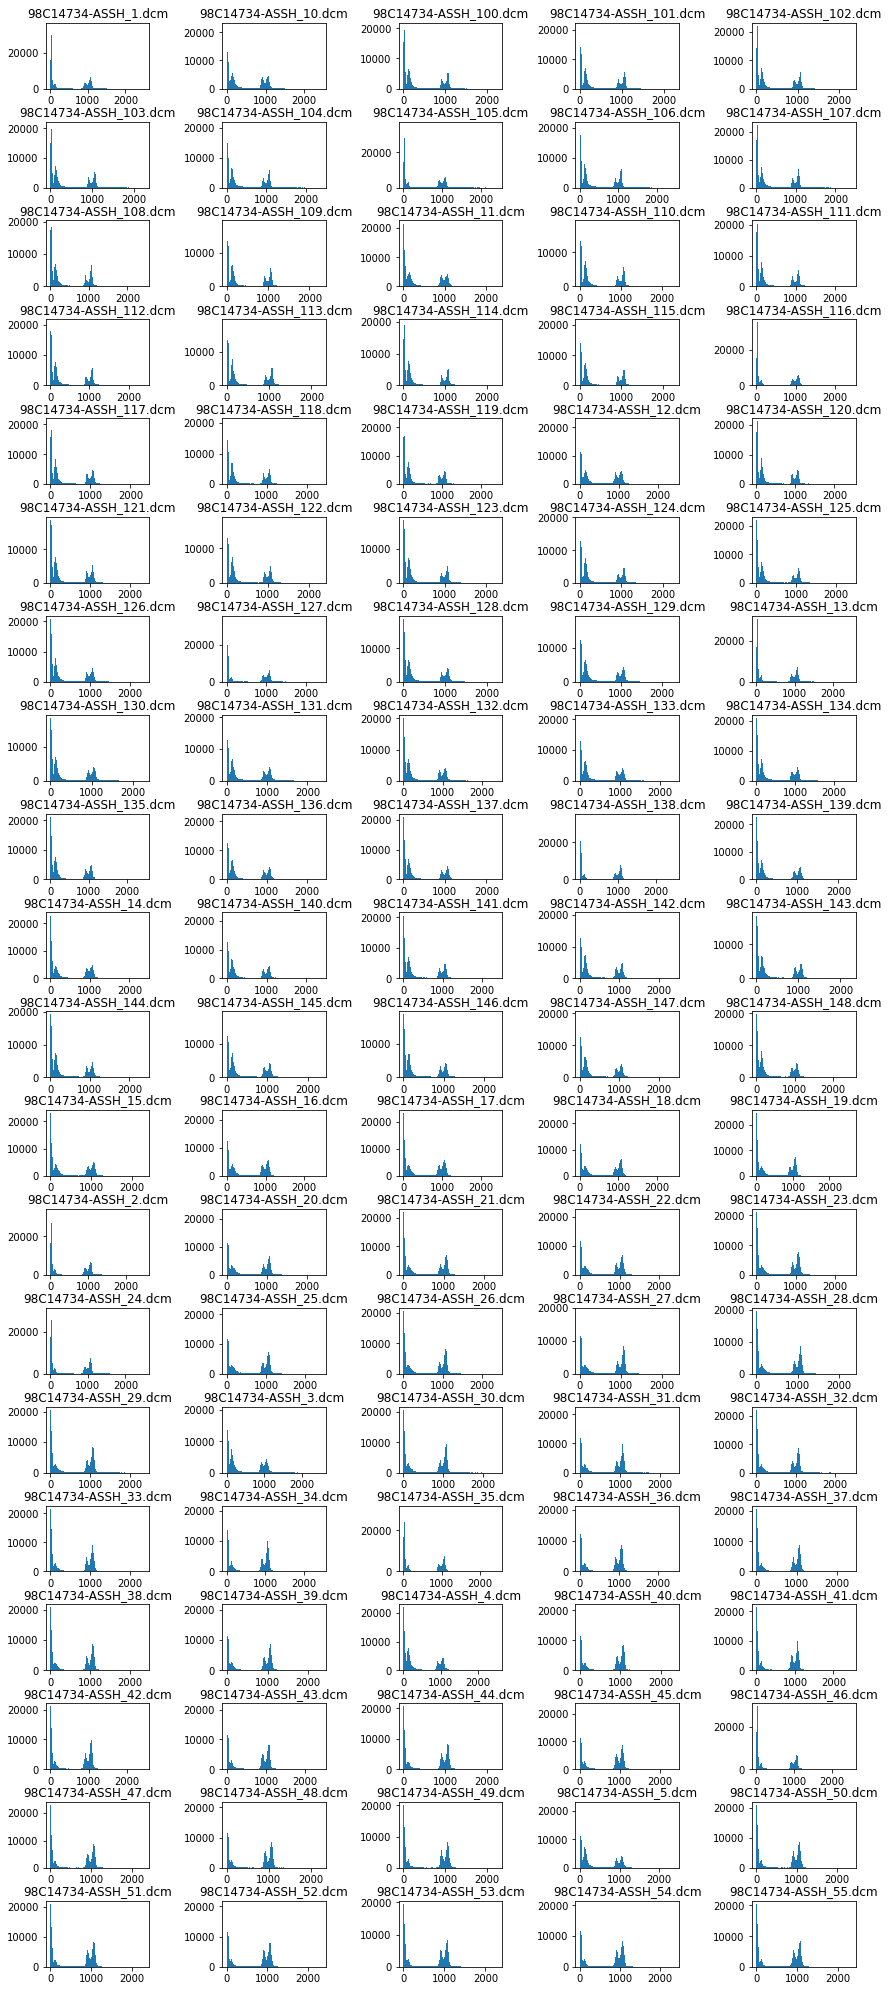

In [5]:
for i,j in enumerate(volume_covid[0:100]):
    plt.rcParams["figure.figsize"] = (30,30)
    plt.subplots_adjust(bottom=0.1, right=0.5, top=1.0, wspace=0.7, hspace=0.5)
    plt.subplot(20,5,i+1,title= str(j[1]))
    plt.hist(j[0].ravel(),bins=256);
    plt.show

In [6]:
volume_compare = []
volume_compare.append([pydicom.dcmread('Covid/98C14734-ASSH_137.dcm').pixel_array])
volume_compare.append([pydicom.dcmread('Non_Covid/99C628-ASAD_121.dcm').pixel_array])

In [7]:
import numpy as np
volume = np.array(volume_compare)
volume = volume.reshape(2,512,512)

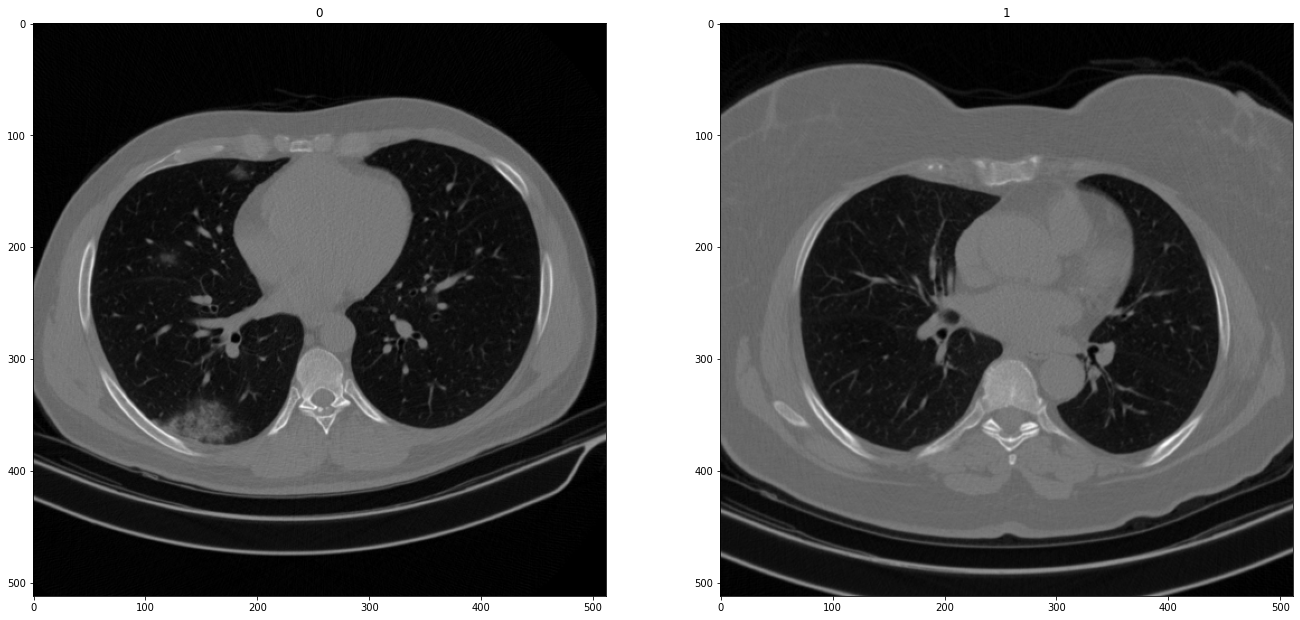

In [8]:
for i,j in enumerate(volume):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.subplots_adjust(bottom=0.1, right=1.0, top=0.9)
    plt.subplot(1,2,i+1,title= str(i))
    plt.imshow(j,cmap='gray')

Text(0.5, 1.0, 'Hist cumulé non covid im1')

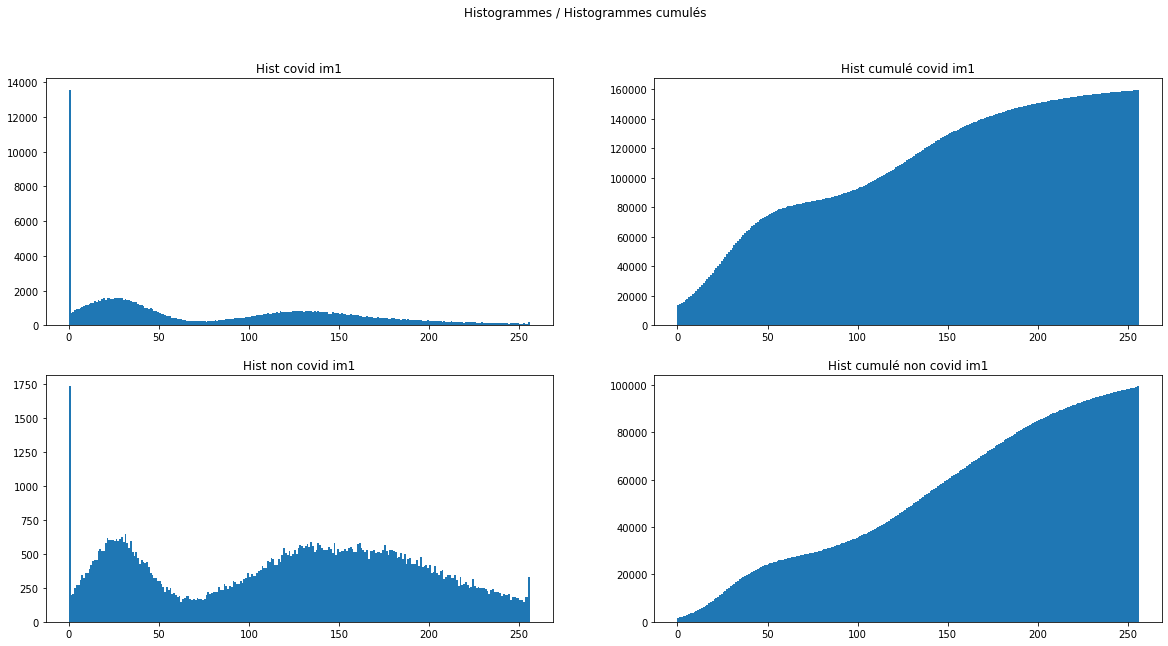

In [9]:
im1 = pydicom.dcmread('Covid/98C14734-ASSH_137.dcm').pixel_array
im2 = pydicom.dcmread('Non_Covid/99C628-ASAD_121.dcm').pixel_array
fig, axs = plt.subplots(2,2)
plt.rcParams["figure.figsize"] = (20,20)
fig.suptitle('Histogrammes / Histogrammes cumulés')
axs[0][0].hist(im1.ravel(),256,[0,256])
axs[0][0].set_title('Hist covid im1')
axs[0][1].hist(im1.ravel(),256,[0,256], cumulative=True)
axs[0][1].set_title('Hist cumulé covid im1')
axs[1][0].hist(im2.ravel(),256,[0,256])
axs[1][0].set_title('Hist non covid im1')
axs[1][1].hist(im2.ravel(),256,[0,256], cumulative=True)
axs[1][1].set_title('Hist cumulé non covid im1')

Text(0.5, 1.0, 'thresold non covid im2')

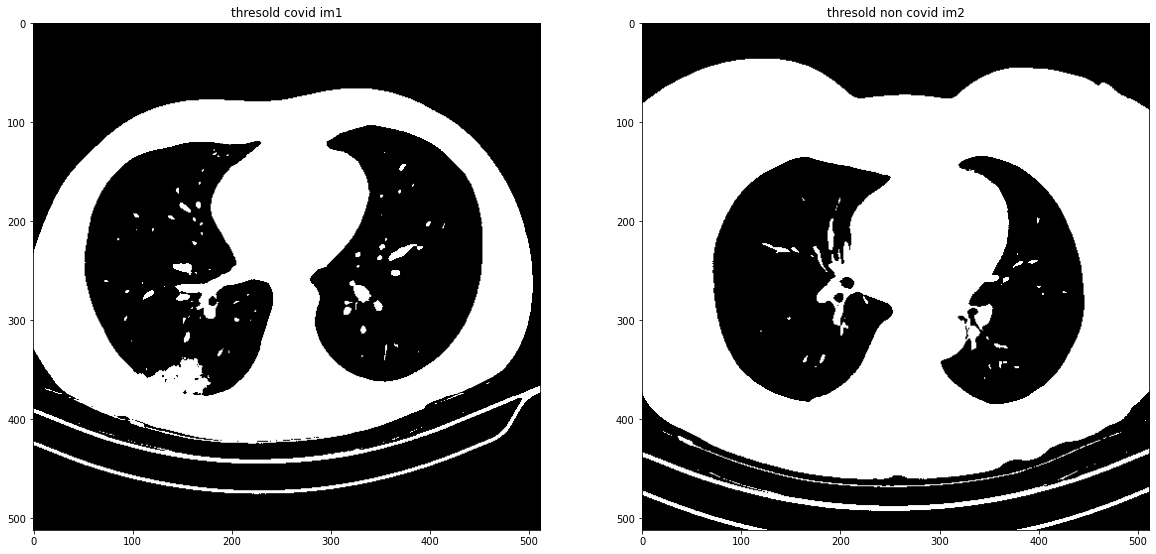

In [10]:
# Seuillage des images 
from medpy.filter import otsu
threshold = otsu(im1)
im1_thresholded = im1 > threshold

threshold = otsu(im2)
im2_thresholded = im2 > threshold

plt.rcParams["figure.figsize"] = (20,20)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im1_thresholded,cmap='gray')
ax1.set_title('thresold covid im1')
ax2.imshow(im2_thresholded,cmap='gray')
ax2.set_title('thresold non covid im2')

c:\users\damin\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\signaltools.py:1475: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\users\damin\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\signaltools.py:1475: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


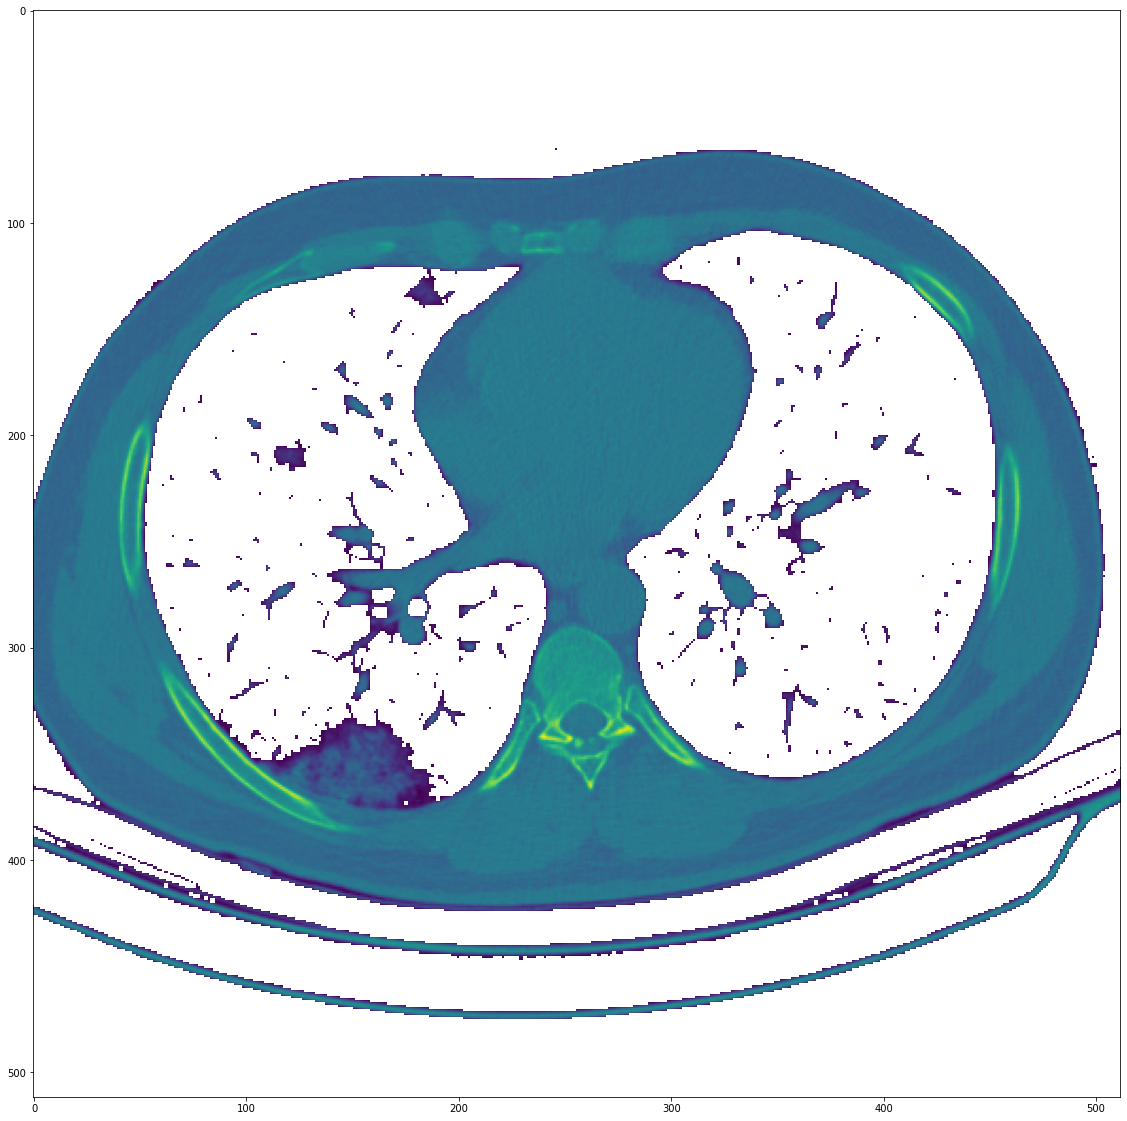

In [11]:
# Filtres de Wiener
from scipy.misc import face
from scipy.signal.signaltools import wiener
filtered_img = wiener(im1, (1,1)) 
plt.imshow(filtered_img)

In [12]:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import copy
from math import *

In [13]:
# Segmentation 
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

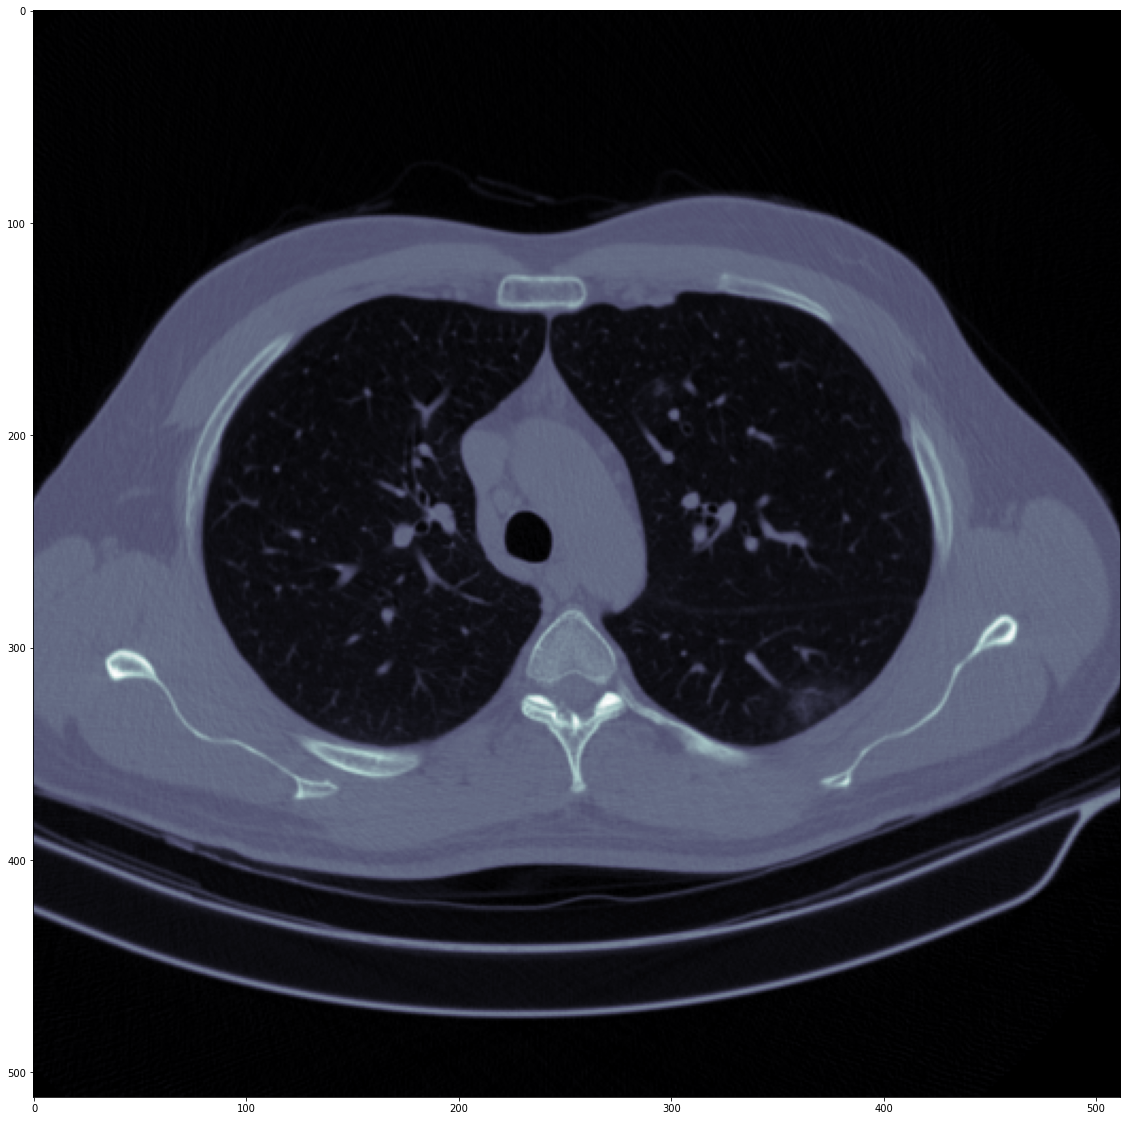

In [24]:
# set path and load files 
path = 'Covid'
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
#sanity check
plt.imshow(patient_pixels[46], cmap=plt.cm.bone)

In [15]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is air.
    # Improvement: Pick multiple background labels from around the patient
    # More resistant to “trays” on which the patient lays cutting the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [16]:
im1.shape

(512, 512)

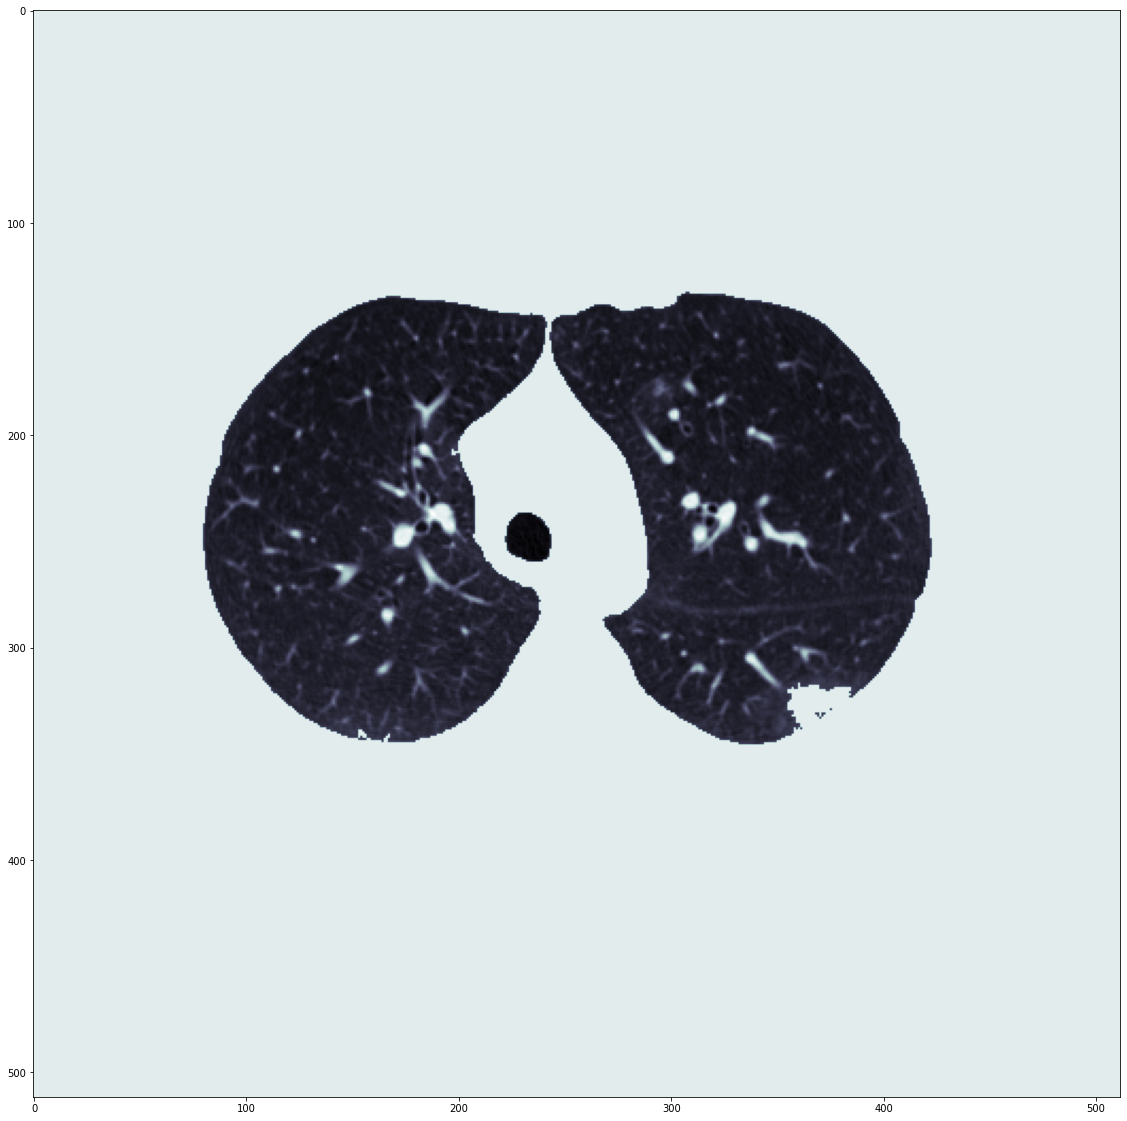

In [17]:
# get masks 
segmented_lungs = segment_lung_mask(patient_pixels,fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(patient_pixels,fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(seg_lung_pixels[46], cmap=plt.cm.bone)

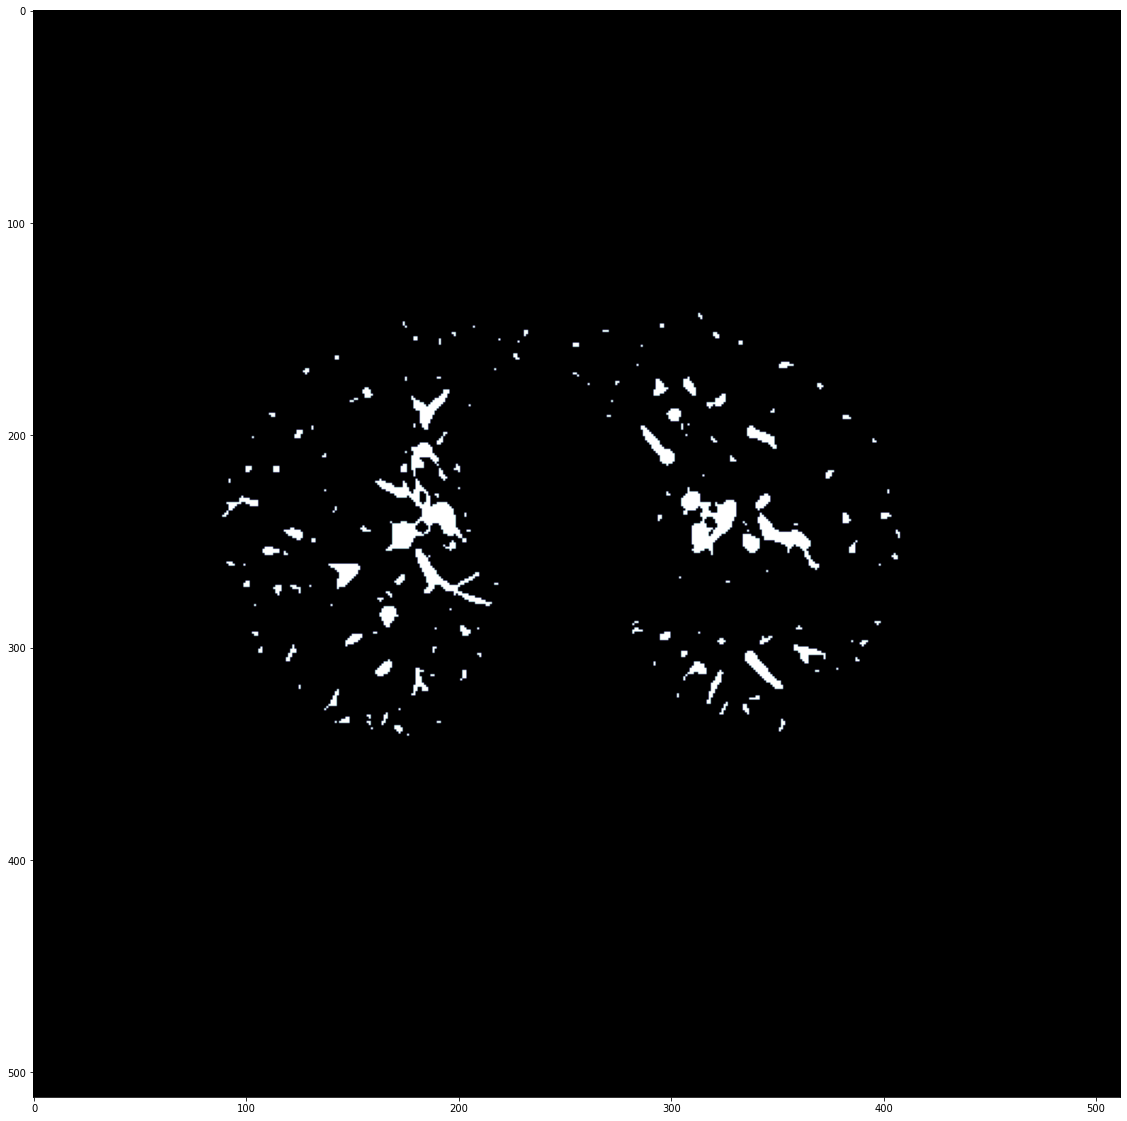

In [26]:
plt.imshow(internal_structures[46], cmap=plt.cm.bone)

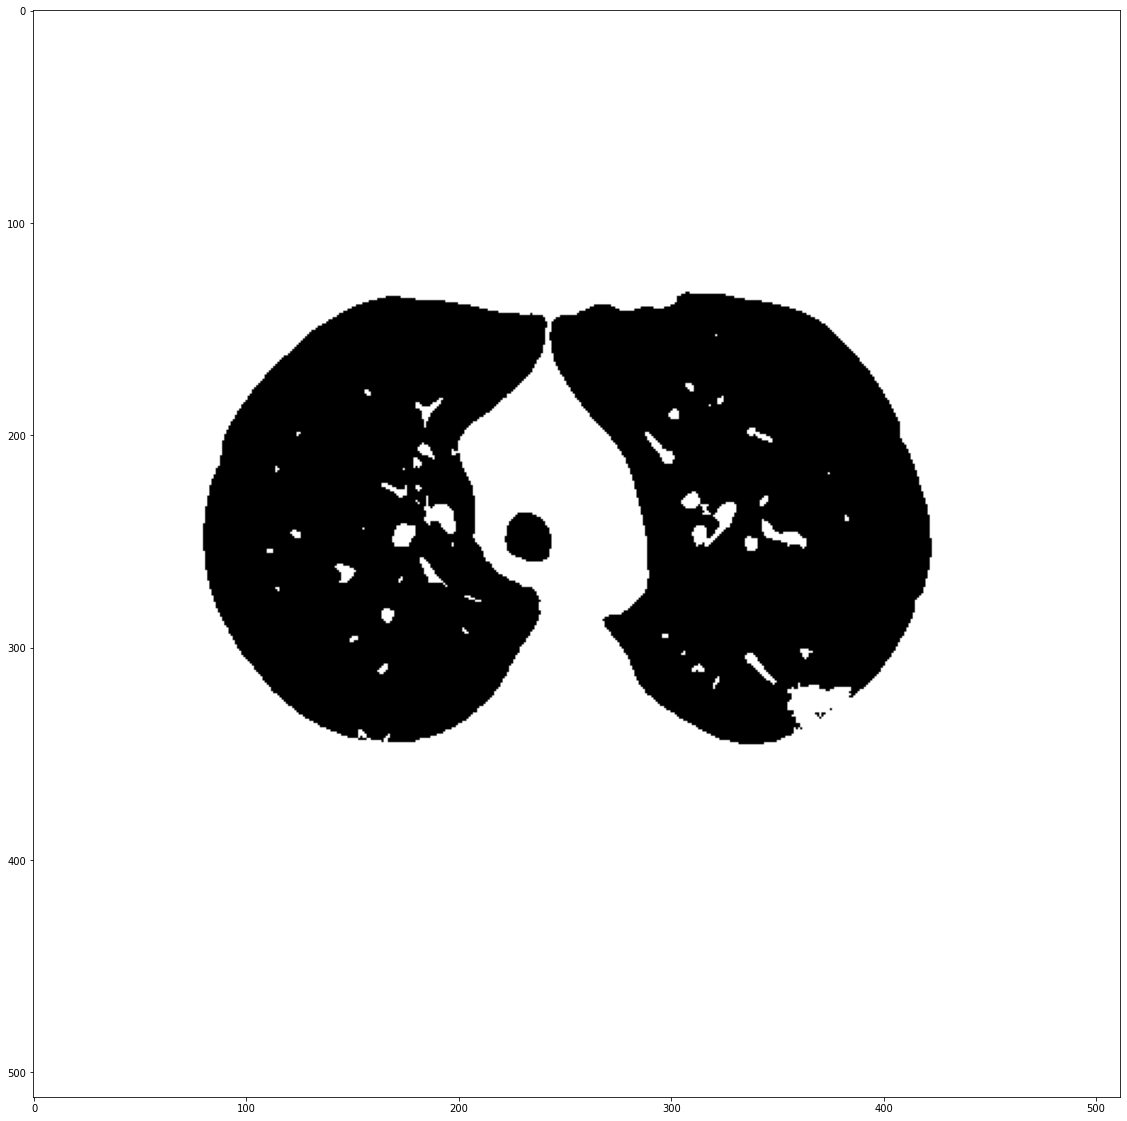

In [18]:
im2 = seg_lung_pixels[46]
threshold = otsu(im2)
im2_thresholded = im2 > threshold
plt.imshow(im2_thresholded,cmap='gray')

Amine Diab, Thomas Clerc